# Hyperparameter Optimization for Stance Classification (OPTUNA)

The goal of this notebook is to optimize the macro F1-score of a stance classification model using hyperparameter optimization (HPO) techniques with Optuna.
We fine-tune our winner model (Best Performance) on a balanced dataset (Previously Augmented) of tweets labeled as support or oppose.

We incorporate:
- Bayesian Optimization (TPE Sampler) to efficiently explore the hyperparameter space.
- Early Stopping to prevent overfitting by stopping training.
- Pruning (Median Pruner) to terminate unpromising trials early and save GPU time.
- Evaluation Metrics: Accuracy, Precision, Recall, and F1-score (macro).

In [1]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from tqdm.auto import tqdm
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import warnings
import json
warnings.filterwarnings('ignore')

# Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data from Google Drive: {path}")
else:
    path = "C:/Users/diego/Desktop/Master Neuro/M2/Intership_NLP/multimodal-argmining"
    os.chdir(path)
    print(f"Loading data locally from: {path}")


# GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU ready:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detecting, using CPU.")

#If we use the augmented dataset:
augmented = True

# Set Seed
seed=42
np.random.seed(seed)
torch.manual_seed(seed)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data from Google Drive: /content/drive/MyDrive/multimodal-argmining
GPU ready: Tesla T4


In [2]:
# Load Dataset
if augmented:
  train_path = f"{path}/data/train_augmented_paraphrase.csv"
else:
  train_path = f"{path}/data/train.csv"

dev_path   = f"{path}/data/dev.csv"
test_path  = f"{path}/data/test.csv"

df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)


# Map labels to ints
label2id = {"oppose": 0, "support": 1}

#Minimal Preprocessing
def clean_tweet(text):

    text = str(text)
    #URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace symbols
    # text = text.replace("&amp;", "&").replace("&lt;", "<").replace("&gt;", ">")
    # # Remove multiple spaces
    # text = re.sub(r'\s+', ' ', text).strip()


    # # Split the words inside Hashtag (#ILoveMexico -> # I Love Mexico)
    # def separar_hashtag(match):
    #     hashtag = match.group(1)
    #     separado = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
    #     return f"# {separado}"

    # text = re.sub(r"#(\w+)", separar_hashtag, text)

    return text


for df in [df_train, df_dev, df_test]:
    df["tweet_text"] = df["tweet_text"].apply(clean_tweet)
    df["label"] = df["stance"].map(label2id)


dataset_train = Dataset.from_pandas(df_train[["tweet_text","label"]])
dataset_dev   = Dataset.from_pandas(df_dev[["tweet_text","label"]])
dataset_test  = Dataset.from_pandas(df_test[["tweet_text","label"]])

In [3]:
# We define our Model
MODEL_NAME = "roberta-base"
MAX_LEN=105

In [4]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
print(f"Tokenizer loaded: {MODEL_NAME}")


# Tokenization Function for each model
def tokenize_dataset(dataset, tokenizer, max_length=MAX_LEN):

    def tokenize_batch(batch):
        return tokenizer(batch["tweet_text"],padding="max_length",truncation=True,max_length=max_length)

    #Tokenization
    tokenized = dataset.map(tokenize_batch, batched=True)

    #Dataset Format for PyTorch
    tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    return tokenized

# Tokenize datasets with model tokenizer
train_dataset_tok = tokenize_dataset(dataset_train, tokenizer, MAX_LEN)
dev_dataset_tok = tokenize_dataset(dataset_dev, tokenizer, MAX_LEN)
test_dataset_tok = tokenize_dataset(dataset_test, tokenizer, MAX_LEN)

print(f"Tokenization complete")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizer loaded: roberta-base


Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenization complete


In [5]:
#Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# We define our Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    return {"accuracy": acc,"f1": f1_macro,"precision": precision,"recall": recall}

### Hyperparameter Optimization - OPTUNA

In [7]:
# Objective Function for Hyperparameter Optimization (OPTUNA)
def objective(trial):

    # Hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 3e-5, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    per_device_train_batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_train_epochs = trial.suggest_int("num_train_epochs", 3, 8)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.2)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)

    # New Model for each trial
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        hidden_dropout_prob=dropout,
        attention_probs_dropout_prob=dropout).to(device)

    # Training Arguments
    training_args = TrainingArguments(
        output_dir=f"./optuna-trial-{trial.number}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_train_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        report_to="none",
        logging_strategy="epoch"
    )

    # Trainer with Early Stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_tok,
        eval_dataset=dev_dataset_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    # Training loop with pruning (More efficient)
    for epoch in range(num_train_epochs):
        trainer.train()
        eval_results = trainer.evaluate(dev_dataset_tok)
        f1_macro = eval_results["eval_f1"]

        # We Report to Optuna
        trial.report(f1_macro, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Final evaluation (F1 score)
    final_metrics = trainer.evaluate(dev_dataset_tok)
    return final_metrics["eval_f1"]

We use **TPESampler** because it efficiently explores the hyperparameter space by learning from previous trials. Unlike random search, it focuses on promising regions, increasing the chances of finding optimal hyperparameters faster and with fewer trials. It is especially useful for mixed spaces with continuous, integer, and categorical parameters.

In [8]:
# We create and run the Optuna study
study = optuna.create_study(direction="maximize",
                            sampler=TPESampler(seed=seed),
                            pruner=MedianPruner(n_warmup_steps=2))


study.optimize(objective, n_trials=6, timeout=None)

print("Best trial:")
print(study.best_trial.params)
print("Best F1:", study.best_trial.value)

[I 2025-10-30 08:48:31,105] A new study created in memory with name: no-name-ce456e66-b163-447b-a06e-3f0695ed2f25
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.695400,0.684349,0.740000,0.687462,0.737634,0.678783
2,0.661000,0.614615,0.755000,0.744252,0.740820,0.754665
3,0.543900,0.541633,0.750000,0.743432,0.743860,0.762377


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.518800,0.413273,0.805000,0.786413,0.791667,0.782386
2,0.420100,0.351254,0.850000,0.827665,0.862696,0.811994
3,0.376100,0.339352,0.865000,0.847934,0.870238,0.835455


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.370300,0.352051,0.860000,0.837794,0.880631,0.819868
2,0.322200,0.360467,0.865000,0.842909,0.890073,0.823805
3,0.303700,0.335489,0.875000,0.856975,0.891369,0.840416


[I 2025-10-30 08:58:01,671] Trial 0 finished with value: 0.8569753139391859 and parameters: {'learning_rate': 3.574712922600241e-06, 'weight_decay': 0.09507143064099162, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.011616722433639893, 'dropout': 0.2598528437324805}. Best is trial 0 with value: 0.8569753139391859.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.538600,0.300606,0.850000,0.836227,0.840912,0.832381
2,0.256500,0.280175,0.880000,0.862132,0.900313,0.844353
3,0.181100,0.255148,0.895000,0.883434,0.897978,0.873638
4,0.117500,0.283724,0.905000,0.895256,0.906038,0.887337


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.138200,0.400806,0.885000,0.876314,0.875268,0.877413
2,0.101300,0.464341,0.905000,0.895256,0.906038,0.887337
3,0.054500,0.552341,0.900000,0.889368,0.901994,0.880488
4,0.026200,0.578017,0.895000,0.884231,0.894731,0.876551


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.062400,0.611297,0.885000,0.873205,0.883424,0.865764
2,0.059400,0.712751,0.880000,0.865335,0.886071,0.853090
3,0.016400,0.756515,0.885000,0.869463,0.898616,0.854115


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.062900,0.508772,0.915000,0.907486,0.911538,0.903948
2,0.042600,0.585113,0.890000,0.880642,0.883066,0.878438
3,0.015600,0.618062,0.900000,0.888592,0.905573,0.877575


[I 2025-10-30 09:12:56,150] Trial 1 finished with value: 0.907485510598351 and parameters: {'learning_rate': 7.72537838930735e-06, 'weight_decay': 0.07080725777960455, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03636499344142013, 'dropout': 0.055021352956030146}. Best is trial 1 with value: 0.907485510598351.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.691100,0.685455,0.740000,0.690476,0.734251,0.681696
2,0.678300,0.671041,0.730000,0.719888,0.717785,0.732068
3,0.649300,0.649449,0.735000,0.724525,0.721997,0.736005


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.556000,0.459257,0.775000,0.756592,0.757378,0.755852
2,0.410500,0.386748,0.810000,0.789800,0.799430,0.783411
3,0.361800,0.367705,0.805000,0.780350,0.798810,0.770737


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.343300,0.334323,0.845000,0.826695,0.843268,0.816794
2,0.292700,0.297600,0.865000,0.847934,0.870238,0.835455
3,0.260900,0.291293,0.865000,0.847934,0.870238,0.835455


[I 2025-10-30 09:21:25,931] Trial 2 finished with value: 0.8479344428486948 and parameters: {'learning_rate': 2.814509271606063e-06, 'weight_decay': 0.052475643163223784, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.058428929707043636, 'dropout': 0.1099085529881075}. Best is trial 1 with value: 0.907485510598351.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.695200,0.672529,0.750000,0.702381,0.748157,0.692482
2,0.493800,0.367545,0.835000,0.815514,0.831580,0.806008
3,0.328300,0.325609,0.835000,0.816824,0.829044,0.808920


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.275000,0.267600,0.885000,0.870463,0.894048,0.857027
2,0.215400,0.259692,0.885000,0.874038,0.880793,0.868677
3,0.175900,0.256749,0.885000,0.873205,0.883424,0.865764


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.176700,0.252099,0.900000,0.887779,0.909659,0.874663
2,0.135300,0.271046,0.890000,0.879121,0.887667,0.872614
3,0.104100,0.280475,0.895000,0.884991,0.891934,0.879463


[I 2025-10-30 09:30:14,496] Trial 3 finished with value: 0.8877791493659521 and parameters: {'learning_rate': 4.7170520376251735e-06, 'weight_decay': 0.07851759613930137, 'batch_size': 32, 'num_train_epochs': 3, 'warmup_ratio': 0.12150897038028768, 'dropout': 0.051157237106187456}. Best is trial 1 with value: 0.907485510598351.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.707200,0.672005,0.635000,0.388379,0.317500,0.500000
2,0.690900,0.673320,0.635000,0.388379,0.317500,0.500000
3,0.683300,0.673492,0.695000,0.544351,0.837766,0.582192


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.618900,0.458100,0.785000,0.767410,0.768229,0.766638
2,0.444900,0.385289,0.825000,0.816519,0.811371,0.827257
3,0.382600,0.367549,0.830000,0.822157,0.816880,0.834106


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.350900,0.311597,0.875000,0.867693,0.862500,0.875364
2,0.307100,0.289062,0.880000,0.873297,0.867621,0.882213
3,0.274800,0.281196,0.890000,0.883277,0.878335,0.890087


[I 2025-10-30 09:39:47,466] Trial 4 finished with value: 0.883276740237691 and parameters: {'learning_rate': 1.247639427256944e-06, 'weight_decay': 0.09488855372533334, 'batch_size': 8, 'num_train_epochs': 3, 'warmup_ratio': 0.1368466053024314, 'dropout': 0.13204574812188039}. Best is trial 1 with value: 0.907485510598351.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.711800,0.673640,0.635000,0.388379,0.317500,0.500000
2,0.691100,0.677313,0.635000,0.388379,0.317500,0.500000
3,0.684000,0.673012,0.740000,0.698760,0.726608,0.690433
4,0.630500,0.579316,0.720000,0.712644,0.713784,0.730018
5,0.535400,0.501070,0.760000,0.750000,0.746618,0.761514
6,0.495900,0.491033,0.745000,0.735963,0.733838,0.749703


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.476100,0.391000,0.805000,0.790272,0.789468,0.791123
2,0.388400,0.334739,0.850000,0.840000,0.836765,0.844030
3,0.338300,0.297237,0.865000,0.853065,0.856593,0.850016
4,0.302300,0.277094,0.875000,0.863949,0.867582,0.860803
5,0.288300,0.273477,0.870000,0.858063,0.863038,0.853953
6,0.282100,0.271121,0.870000,0.858063,0.863038,0.853953


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.296800,0.261953,0.875000,0.863085,0.869652,0.857890
2,0.264600,0.261224,0.885000,0.875592,0.876736,0.874501
3,0.243600,0.238851,0.890000,0.876557,0.897865,0.863877
4,0.217800,0.242505,0.895000,0.882600,0.901706,0.870726
5,0.223900,0.238559,0.900000,0.889368,0.901994,0.880488
6,0.207300,0.236894,0.895000,0.884231,0.894731,0.876551


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.212400,0.245504,0.900000,0.889368,0.901994,0.880488
2,0.213700,0.245037,0.895000,0.884231,0.894731,0.876551
3,0.187900,0.243479,0.900000,0.890818,0.896227,0.886312
4,0.180800,0.248209,0.900000,0.888592,0.905573,0.877575
5,0.165300,0.247684,0.900000,0.890110,0.898889,0.883400


[I 2025-10-30 10:02:25,412] Trial 5 pruned. 


Best trial:
{'learning_rate': 7.72537838930735e-06, 'weight_decay': 0.07080725777960455, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03636499344142013, 'dropout': 0.055021352956030146}
Best F1: 0.907485510598351


In [10]:
# Re-train the best model with optimal hyperparameters
best_params = study.best_trial.params
print("\n Retraining best model with optimal hyperparameters...")

best_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    hidden_dropout_prob=best_params["dropout"],
    attention_probs_dropout_prob=best_params["dropout"]
).to(device)

best_args = TrainingArguments(
    output_dir="./roberta_best",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["batch_size"],
    per_device_eval_batch_size=best_params["batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    warmup_ratio=best_params["warmup_ratio"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none",
    logging_strategy="epoch"
)

final_trainer = Trainer(
    model=best_model,
    args=best_args,
    train_dataset=train_dataset_tok,
    eval_dataset=dev_dataset_tok,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

final_trainer.train()
eval_results = final_trainer.evaluate(test_dataset_tok)
print("\n Final evaluation on test set:", eval_results)


 Retraining best model with optimal hyperparameters...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.563500,0.324697,0.870000,0.850643,0.887774,0.833567
2,0.273500,0.283359,0.870000,0.853008,0.878231,0.839392
3,0.196700,0.268128,0.900000,0.888592,0.905573,0.877575
4,0.138300,0.283648,0.895000,0.884991,0.891934,0.879463



 Final evaluation on test set: {'eval_loss': 0.5504055023193359, 'eval_accuracy': 0.84, 'eval_f1': 0.8354285714285714, 'eval_precision': 0.8319805194805194, 'eval_recall': 0.8428012665300801, 'eval_runtime': 1.8599, 'eval_samples_per_second': 161.297, 'eval_steps_per_second': 10.215, 'epoch': 4.0}


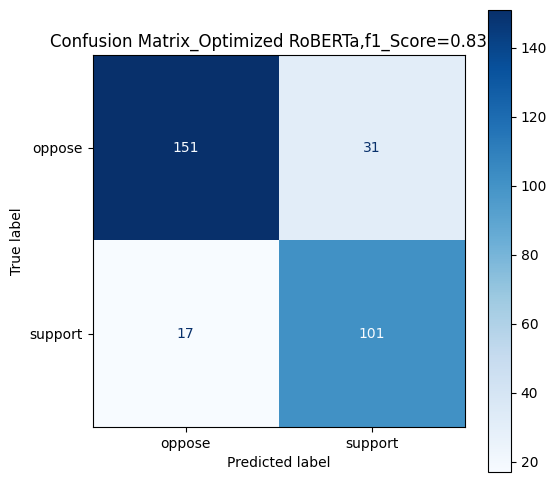

In [11]:
# Path Output
os.makedirs(f"{path}/experiments/text/HPO/", exist_ok=True)
output_dir = f"{path}/experiments/text/HPO/"

# Confusion Matrix
preds_output = final_trainer.predict(test_dataset_tok)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["oppose", "support"])

# Export
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=ax)
plt.title(f"Confusion Matrix_Optimized RoBERTa,f1_Score={eval_results['eval_f1']:.4f}")
save_path = os.path.join(output_dir,f"confusion_matrix_Model_Optimized.jpg")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()



In [12]:
# Export metrics to CSV
metrics_dict = eval_results
metrics_dict["best_trial_f1_dev"] = study.best_trial.value
results_df = pd.DataFrame([metrics_dict])
results_df.to_csv(output_dir + "evaluation_results.csv", index=False)
print(f"Metrics saved to {output_dir}/evaluation_results.csv")
print(results_df)

Metrics saved to /content/drive/MyDrive/multimodal-argmining/experiments/text/HPO//evaluation_results.csv
   eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0   0.550406           0.84  0.835429        0.831981     0.842801   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  \
0        1.8599                  161.297                 10.215    4.0   

   best_trial_f1_dev  
0           0.907486  


In [13]:
# Export best hyperparameters to JSON
best_hyperparams = study.best_trial.params
with open(f"{output_dir}/best_hyperparameters.json", "w") as f:
    json.dump(best_hyperparams, f, indent=4)
print(f"Best hyperparameters saved to {output_dir}/best_hyperparameters.json")
print(best_hyperparams)

Best hyperparameters saved to /content/drive/MyDrive/multimodal-argmining/experiments/text/HPO//best_hyperparameters.json
{'learning_rate': 7.72537838930735e-06, 'weight_decay': 0.07080725777960455, 'batch_size': 16, 'num_train_epochs': 4, 'warmup_ratio': 0.03636499344142013, 'dropout': 0.055021352956030146}
